<a href="https://colab.research.google.com/github/Ware-Hard-or-Soft/Generative-Models/blob/main/Generative_Models_Variational_Autoencoders_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE




By David Zheng

## From AE to VAE for image de-noising
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images.

### Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1).

In [2]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt
# Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.3):
            self.std = std
            self.mean = mean

    def __call__(self, tensor):
          return tensor + torch.randn(tensor.size()) * self.std + self.mean



transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

1.5062122344970703
-0.803291380405426


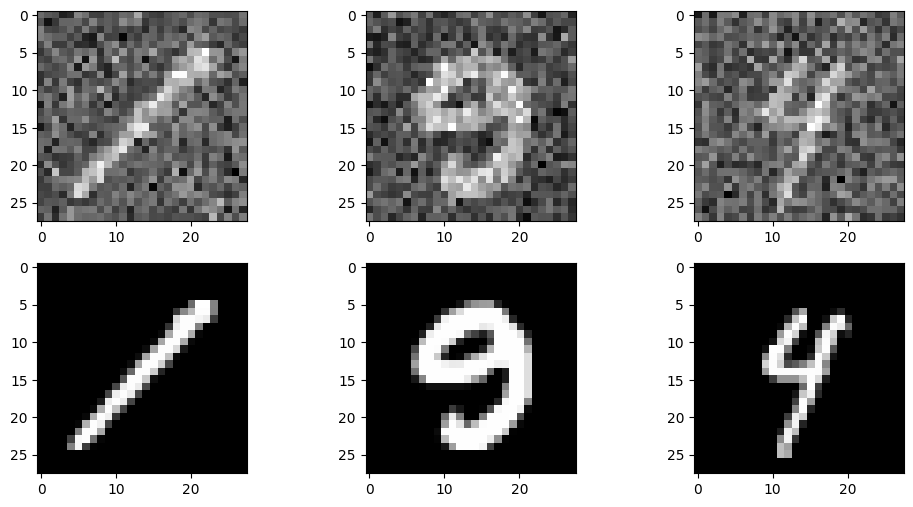

In [3]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

# Plot the first 3 training images with corresponding noisy images

import matplotlib.pyplot as plt

batch_idx, (noisy_images, orignal_images) = next(enumerate(train_loader))

fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(noisy_images[idx][0], cmap='gray')



  ax[1,idx].imshow(orignal_images[idx][0], cmap='gray')


fig.show()


### Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

In [5]:
###########################   <YOUR CODE>  ############################
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
latent_feature=16

class our_AE(nn.Module):
  def __init__(self):
    super(our_AE, self).__init__()

    # encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=512)
    self.en_fc2 = nn.Linear(in_features=512, out_features=512)
    self.en_fc3 = nn.Linear(in_features=512, out_features=latent_feature)

    # decoder
    self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=512)
    self.de_fc2 = nn.Linear(in_features=512, out_features=512)
    self.de_fc3 = nn.Linear(in_features=512, out_features=784)

  def forward(self, x):

    # encoding layers
    x = x.view(-1, 784)
    x = F.relu(self.en_fc1(x))
    x = F.relu(self.en_fc2(x))
    x = F.relu(self.en_fc3(x))
    # decoding layers
    x = F.relu(self.de_fc1(x))
    x = F.relu(self.en_fc2(x))
    x = torch.sigmoid(self.de_fc3(x))
    x = x.view(-1, 1, 28, 28)
    return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available, otherwise use CPU
AE = our_AE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

In [6]:
def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (noisy_images, orignal_images) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    noisy_images = noisy_images.to(device)
    orignal_images = orignal_images.to(device)
    output = AE(noisy_images)
    loss = loss_fn(output, orignal_images) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(noisy_images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for noisy_images, orignal_images in test_loader:
      noisy_images = noisy_images.to(device)
      orignal_images = orignal_images.to(device)
      output = AE(noisy_images)
      print(output.shape)
      test_loss += loss_fn(output, orignal_images).item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 4

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

Epoch 1: [0/60000] Loss: 180.87135314941406
Epoch 1: [6400/60000] Loss: 56.23988723754883
Epoch 1: [12800/60000] Loss: 51.54343032836914
Epoch 1: [19200/60000] Loss: 48.82157897949219
Epoch 1: [25600/60000] Loss: 46.31399917602539
Epoch 1: [32000/60000] Loss: 40.637306213378906
Epoch 1: [38400/60000] Loss: 40.22317123413086
Epoch 1: [44800/60000] Loss: 39.296180725097656
Epoch 1: [51200/60000] Loss: 34.150123596191406
Epoch 1: [57600/60000] Loss: 35.40201187133789
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
Test result on epoch 1: Avg loss is 32.3153970703125
Epoch 2: [0/60000] Loss: 32.537269592285156
Epoch 2: [6400/60000] Loss: 30.612239837646484
Epoch 2: [12800/60000] Loss: 30.353538513183594
Epoch 2: [19200/60000] Loss: 28.3460063

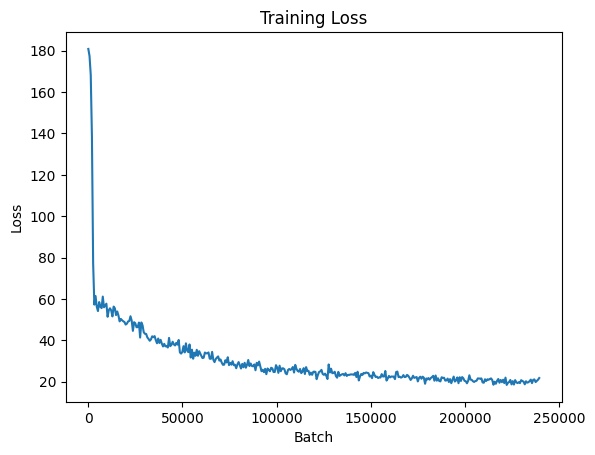

In [10]:
import matplotlib.pyplot as plt # Import the necessary library

# Assuming batch and loss are defined and represent your data
plt.plot(train_counter, train_losses)  # Use plt.plot to create the plot
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()  # Display the plot

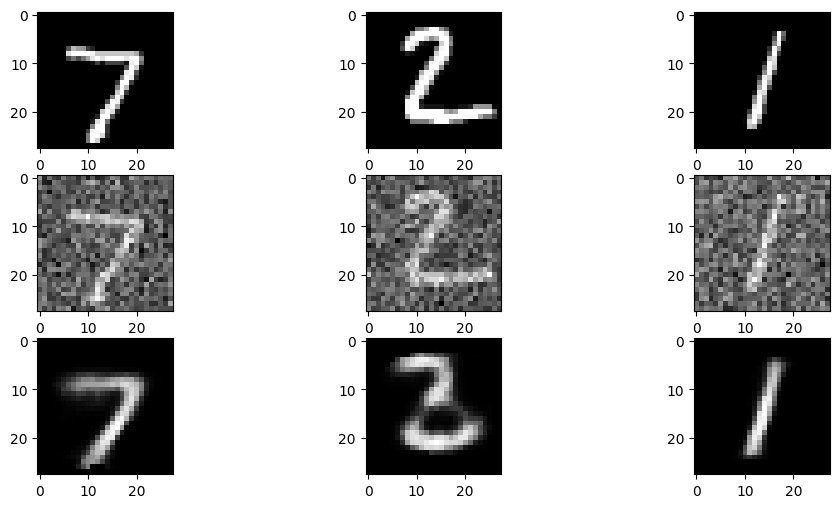

In [11]:
import matplotlib.pyplot as plt

batch_idx, (noisy_images, orignal_images) = next(enumerate(test_loader))
noisy_images = noisy_images.to(device)
output = AE(noisy_images).cpu().detach()
noisy_images = noisy_images.cpu()


fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(orignal_images[idx][0], cmap='gray')
  ax[1,idx].imshow(noisy_images[idx][0], cmap='gray')
  ax[2,idx].imshow(output[idx][0], cmap='gray')
fig.show()


## Build a variational autoencoder(VAE) that can generate MNIST images

### Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [12]:

import torchvision
import torch
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
#import model
from tqdm import tqdm

matplotlib.style.use('ggplot')

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Images already in [0,1]

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

We are using device name "cuda"


### VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels.

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$.


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [13]:

def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  kl = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
  recon_loss = torch.nn.functional.binary_cross_entropy(output, images,reduction="sum")
  ########################  ############################
  return recon_loss, kl


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [14]:
import torch.nn as nn
import torch.nn.functional as F

features=16
class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    self.enc1 = nn.Linear(in_features=784, out_features=512)
    self.enc2 = nn.Linear(in_features=512, out_features=features*2)

    # decoder
    self.dec1 = nn.Linear(in_features=features, out_features=512)
    self.dec2 = nn.Linear(in_features=512, out_features=784)


  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using
    the reparameterization trick.
    """


    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    sample = mu + (eps * std)
    #########################
    return sample

  def encoder(self, x):
  ##
    x = F.relu(self.enc1(x))
    x = self.enc2(x).view(-1, 2, features)
    mu = x[:, 0, :]
    log_var = x[:, 1, :]
    z = self.reparameterize(mu, log_var)
    ###########################################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    #############################################
    x = F.relu(self.dec1(z))
    x = torch.sigmoid(self.dec2(x))

    ###########################################
    return x


  def forward(self, x):

    mu=self.encoder(x)[0]
    log_var=self.encoder(x)[1]
    z=self.encoder(x)[2]
    x=self.decoder(z)

    return x, mu, log_var
#CUDA_LAUNCH_BLOCKING=1
model = our_VAE().to(device)

### Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

In [15]:
##########################################
ELBO = []
Recon =[]
KL = []
Batch=[]

epochs = 10
batch_size = 64
lr = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=lr)

def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        vaeLoss=vae_loss(reconstruction, mu, logvar, data)
        loss = vaeLoss[0]+vaeLoss[1]
        rl=vaeLoss[0]
        kl=vaeLoss[1]
        loss += loss.item()
        rl+= rl.item()
        kl+= kl.item()
        loss.backward()
        optimizer.step()
        if i % 10 == 0 and not i == 0: # We record our output every 10 batches
          ELBO.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
          Recon.append(rl.item()/batch_size_train)
          KL.append(kl.item()/batch_size_train)
          Batch.append(i)
        if i % 100 == 0 and not i == 0:
          print(f'Epoch {epoch}: [{i}/{int(len(train_dataset)/dataloader.batch_size)}] Loss: {loss.item()/batch_size_train}')

    return ELBO,Recon,KL,Batch


############################


In [16]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    m=fit(model, train_loader)
    #val_epoch_loss = validate(model, val_loader)

Epoch 1 of 10
Epoch 0: [100/937] Loss: 448.2511291503906
Epoch 0: [200/937] Loss: 420.62005615234375
Epoch 0: [300/937] Loss: 402.3788146972656
Epoch 0: [400/937] Loss: 353.7566223144531
Epoch 0: [500/937] Loss: 323.7622985839844
Epoch 0: [600/937] Loss: 308.8608703613281
Epoch 0: [700/937] Loss: 277.84405517578125
Epoch 0: [800/937] Loss: 260.2930603027344
Epoch 0: [900/937] Loss: 266.0093688964844
Epoch 2 of 10
Epoch 1: [100/937] Loss: 267.1417541503906
Epoch 1: [200/937] Loss: 271.37255859375
Epoch 1: [300/937] Loss: 237.58560180664062
Epoch 1: [400/937] Loss: 238.2744598388672
Epoch 1: [500/937] Loss: 219.94772338867188
Epoch 1: [600/937] Loss: 215.09951782226562
Epoch 1: [700/937] Loss: 206.31422424316406
Epoch 1: [800/937] Loss: 214.37936401367188
Epoch 1: [900/937] Loss: 201.91018676757812
Epoch 3 of 10
Epoch 2: [100/937] Loss: 209.6551971435547
Epoch 2: [200/937] Loss: 203.3191375732422
Epoch 2: [300/937] Loss: 211.2552490234375
Epoch 2: [400/937] Loss: 198.19400024414062
Epoch

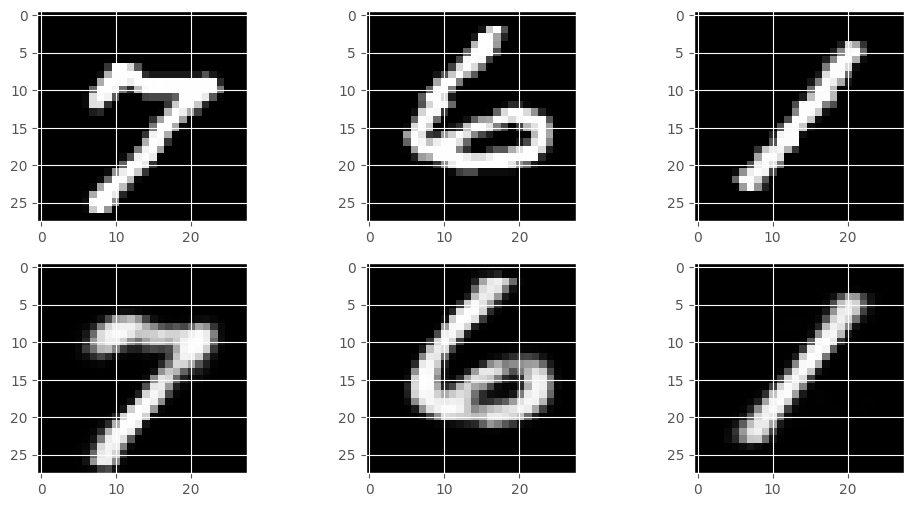

In [17]:
import matplotlib.pyplot as plt
for i, data in enumerate(test_loader):
    data, _ = data
    data = data.to(device)
    data = data.view(data.size(0), -1)
    optimizer.zero_grad()
    reconstruction, mu, logvar = model(data)

output = model(data)[0].cpu().detach()
images = data.cpu()


fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(images[idx].reshape(28, 28), cmap='gray')
  ax[1,idx].imshow(output[idx].reshape(28, 28), cmap='gray')
fig.show()

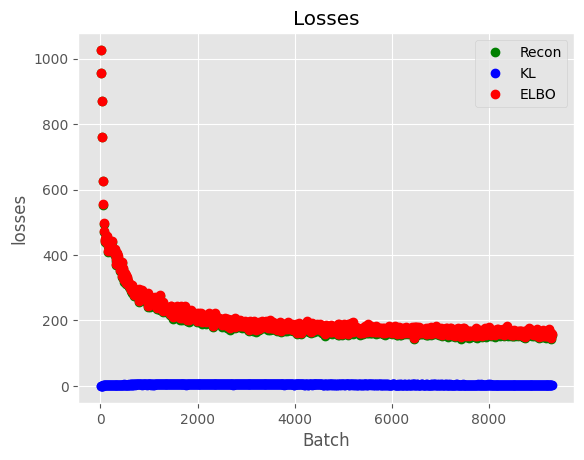

In [18]:
import numpy as np
import matplotlib.pyplot as plt

x=np.linspace(10,9300,930)
plt.plot(x, Recon, 'o', color='green' )
plt.plot(x, KL, 'o', color='blue')
plt.plot(x, ELBO, 'o', color='red')

plt.legend(['Recon','KL','ELBO'])
plt.title('Losses')
plt.xlabel('Batch')
plt.ylabel('losses')


plt.show()

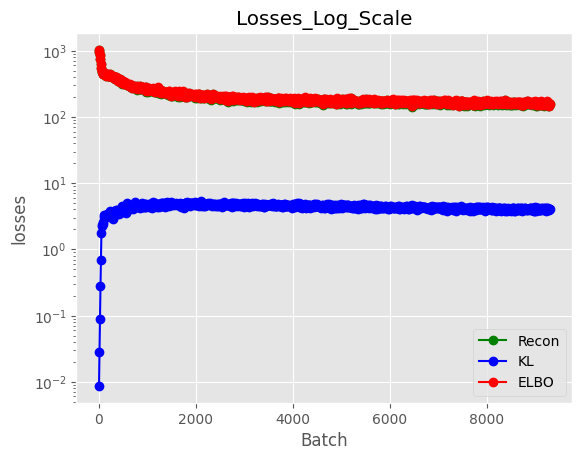

In [19]:
import numpy as np
import matplotlib.pyplot as plt

x=np.linspace(10,9300,930)
plt.plot(x, Recon, 'o-', color='green')
plt.plot(x, KL, 'o-', color='blue' )
plt.plot(x, ELBO, 'o-', color='red')

plt.legend(['Recon','KL','ELBO'])
plt.title('Losses_Log_Scale')
plt.xlabel('Batch')
plt.ylabel('losses')

plt.yscale("log")
plt.show()

### Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task.


In [20]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(images)
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

In [21]:
###########################   <YOUR CODE>  ############################

import torch.nn as nn
import torch.nn.functional as F

features=16
class our_VAE2(nn.Module):
  def __init__(self, latent_feature = 2): # you can use any number of latent features you want in the training
    super(our_VAE2, self).__init__()

    self.latent_feature = latent_feature

    ###########################   <YOUR CODE>  ############################

    self.enc1 = nn.Linear(in_features=784, out_features=512)
    self.enc2 = nn.Linear(in_features=512, out_features=features*2)

    # decoder
    self.dec1 = nn.Linear(in_features=features, out_features=512)
    self.dec2 = nn.Linear(in_features=512, out_features=784)
    #########################  <END YOUR CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using
    the reparameterization trick.
    """
    ###########################   <YOUR CODE>  ############################

    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    sample = mu + (eps * std)
    #########################  <END YOUR CODE>  ############################
    return sample

  def encoder(self, x):

    ###########################   <YOUR CODE>  ############################
    x = F.relu(self.enc1(x))
    x = self.enc2(x).view(-1, 2, features)
    mu = x[:, 0, :]
    log_var = x[:, 1, :]
    z = self.reparameterize(mu, log_var)
    #########################  <END YOUR CODE>  ###########################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    ###########################   <YOUR CODE>  ############################
    x = F.relu(self.dec1(z))
    x = torch.sigmoid(self.dec2(x))

    #########################  <END YOUR CODE>  ###########################
    return x


  def forward(self, x):

    mu=self.encoder(x)[0]
    log_var=self.encoder(x)[1]
    z=self.encoder(x)[2]
    x=self.decoder(z)

    return x, mu, log_var
#CUDA_LAUNCH_BLOCKING=1

model2 = our_VAE2().to(device)
###########################   <YOUR CODE>  ############################
ELBO = []
Recon =[]
KL = []
Batch=[]

epochs = 10
batch_size = 64
lr = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model2.parameters(), lr=lr)

def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model2(data)
        vaeLoss=vae_loss(reconstruction, mu, logvar, data)
        loss = vaeLoss[0]+vaeLoss[1]
        rl=vaeLoss[0]
        kl=vaeLoss[1]
        loss += loss.item()
        rl+= rl.item()
        kl+= kl.item()
        loss.backward()
        optimizer.step()
        if i % 10 == 0 and not i == 0: # We record our output every 10 batches
          ELBO.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
          Recon.append(rl.item()/batch_size_train)
          KL.append(kl.item()/batch_size_train)
          Batch.append(i)
        if i % 100 == 0 and not i == 0:
          print(f'Epoch {epoch}: [{i}/{int(len(train_dataset)/dataloader.batch_size)}] Loss: {loss.item()/batch_size_train}')

    return ELBO,Recon,KL,Batch
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    m=fit(model2, train_loader)
    #val_epoch_loss = validate(model, val_loader)


#########################  <END YOUR CODE>  ###########################

Epoch 1 of 10
Epoch 0: [100/937] Loss: 452.37921142578125
Epoch 0: [200/937] Loss: 427.7801513671875
Epoch 0: [300/937] Loss: 393.4599914550781
Epoch 0: [400/937] Loss: 356.3383483886719
Epoch 0: [500/937] Loss: 333.0523376464844
Epoch 0: [600/937] Loss: 308.2597961425781
Epoch 0: [700/937] Loss: 294.0679016113281
Epoch 0: [800/937] Loss: 282.3876647949219
Epoch 0: [900/937] Loss: 270.82220458984375
Epoch 2 of 10
Epoch 1: [100/937] Loss: 252.79579162597656
Epoch 1: [200/937] Loss: 245.8511199951172
Epoch 1: [300/937] Loss: 242.73915100097656
Epoch 1: [400/937] Loss: 241.41693115234375
Epoch 1: [500/937] Loss: 227.3353271484375
Epoch 1: [600/937] Loss: 217.01376342773438
Epoch 1: [700/937] Loss: 219.00332641601562
Epoch 1: [800/937] Loss: 222.5853271484375
Epoch 1: [900/937] Loss: 217.3980712890625
Epoch 3 of 10
Epoch 2: [100/937] Loss: 205.53065490722656
Epoch 2: [200/937] Loss: 206.1588134765625
Epoch 2: [300/937] Loss: 212.1381072998047
Epoch 2: [400/937] Loss: 201.1187744140625
Epoc

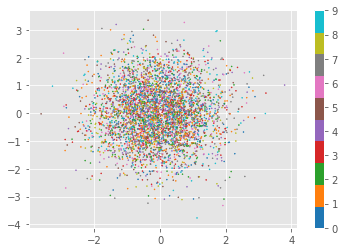

In [ ]:
model2 = our_VAE2().to('cpu')
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(images.reshape(1000,784))
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

plot_latent(model2, test_loader, num_batches=2)

### Task 4.2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space.
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

In [22]:
###########################   <YOUR CODE>  ############################
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Images already in [0,1]
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)
batch_size_train, batch_size_test = 64, 1000
indices0 = test_dataset.targets == 0  #
test_dataset.data0, test_dataset.targets0 = test_dataset.data[indices0], test_dataset.targets[indices0]
test_loader0 = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
indices1 = test_dataset.targets ==1 #
test_dataset.data1, test_dataset.targets1 = test_dataset.data[indices1], test_dataset.targets[indices1]
test_loader1 = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

#########################  <END YOUR CODE>  ###########################

In [24]:
z0list=[]
z1list=[]
for ibx, (images,label) in enumerate(test_loader0):
      images = images.to(device)
      z0=model2.encoder(images.reshape(1000,784))
      z0list.append(z0)
for ibx, (images,label) in enumerate(test_loader1):
      images = images.to(device)
      z1=model2.encoder(images.reshape(1000,784))
      z1list.append(z1)

torch.Size([1000, 16])
torch.Size([1000, 16])
torch.Size([1000, 16])
torch.Size([1000, 16])
torch.Size([1000, 16])
torch.Size([1000, 16])
torch.Size([1000, 16])
torch.Size([1000, 16])
torch.Size([1000, 16])
torch.Size([1000, 16])
torch.Size([1000, 16])


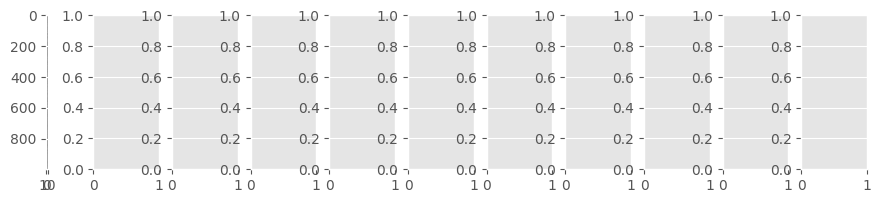

In [30]:
import numpy as np
alpha=np.linspace(0,1,11)
z_hat_list=[]
for m in alpha:
    z_hat=torch.mul(z0[0],float(m))+torch.mul(z1[0],(1-float(m)))
    print(z_hat.shape)
    z_hat_list.append(z_hat)
fig, ax = plt.subplots(1,11)
fig.set_size_inches(11,2)
for idx in range(11):
  ax[0].imshow(z_hat_list[idx].cpu().detach().numpy(), cmap='gray')
fig.show()